# Title : Sales Forecast by Shopping Mall Branch

**Weekly sales for each branch of the shopping mall are predicted based on information on promotion information for each shopping mall store, surrounding weather, unemployment rate, and fuel price.**

**[Data Description]**

id : Sample ID

Store: Shopping mall branch

Date : Weekly Date

Temperature: Temperature around the shopping mall

Fuel_Price: The price of fuel around the shopping mall

Promotions 1 to 5 : De-identified promotion information for the shopping mall

Unemployment: Unemployment in the shopping mall area

Is Holiday: Whether holidays are included in the period

Weekly_Sales: Weekly sales

**[Files]**

train.csv

test.csv

**What problem do you solve?**

It is a matter of predicting sales by shopping mall branch.

# Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import xgboost

import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load Data

In [2]:
trainset = pd.read_csv("input/train.csv")
testset = pd.read_csv("input/test.csv")

# Preprocessing

In [3]:
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number


def preprocessing(data):
    data = data.copy()
    
    # 날짜 형식에 대해 데이터타입 적용
    data.Date = pd.to_datetime(data.Date, format="%d/%m/%Y")
    
    # 날짜 데이터를 주, 일, 월 달 로 분리
    data['Week'] = data.Date.dt.isocalendar().week.apply(lambda x: int(x))
    data['Day'] = data.Date.dt.day.apply(lambda x: int(x))
    data['Year'] = data.Date.dt.year.apply(lambda x: int(x))
    data['Month'] = data.Date.dt.month.apply(lambda x: int(x))
    
    # True/False => 1/0
    data['NumberHoliday'] = data['IsHoliday'].apply(holiday_to_number)
    
    return data

In [4]:
# 데이터 전처리
trainset = preprocessing(trainset)
testset = preprocessing(testset)

In [5]:
trainset

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Day,Year,Month,NumberHoliday
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90,5,5,2010,2,0
1,2,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44,6,12,2010,2,1
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17,7,19,2010,2,0
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59,8,26,2010,2,0
4,5,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68,9,5,2010,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,35,31,2012,8,0
6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,36,7,2012,9,1
6252,6253,45,2012-09-14,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27,37,14,2012,9,0
6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,38,21,2012,9,0


# EDA

**Correlation**

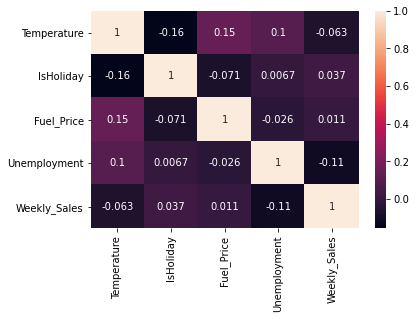

In [6]:
sns.heatmap(trainset[['Date', 'Temperature', 'IsHoliday', 'Fuel_Price', 'Unemployment', 'Weekly_Sales']].corr(), annot = True)
plt.show()

**Annual Sales Trends**

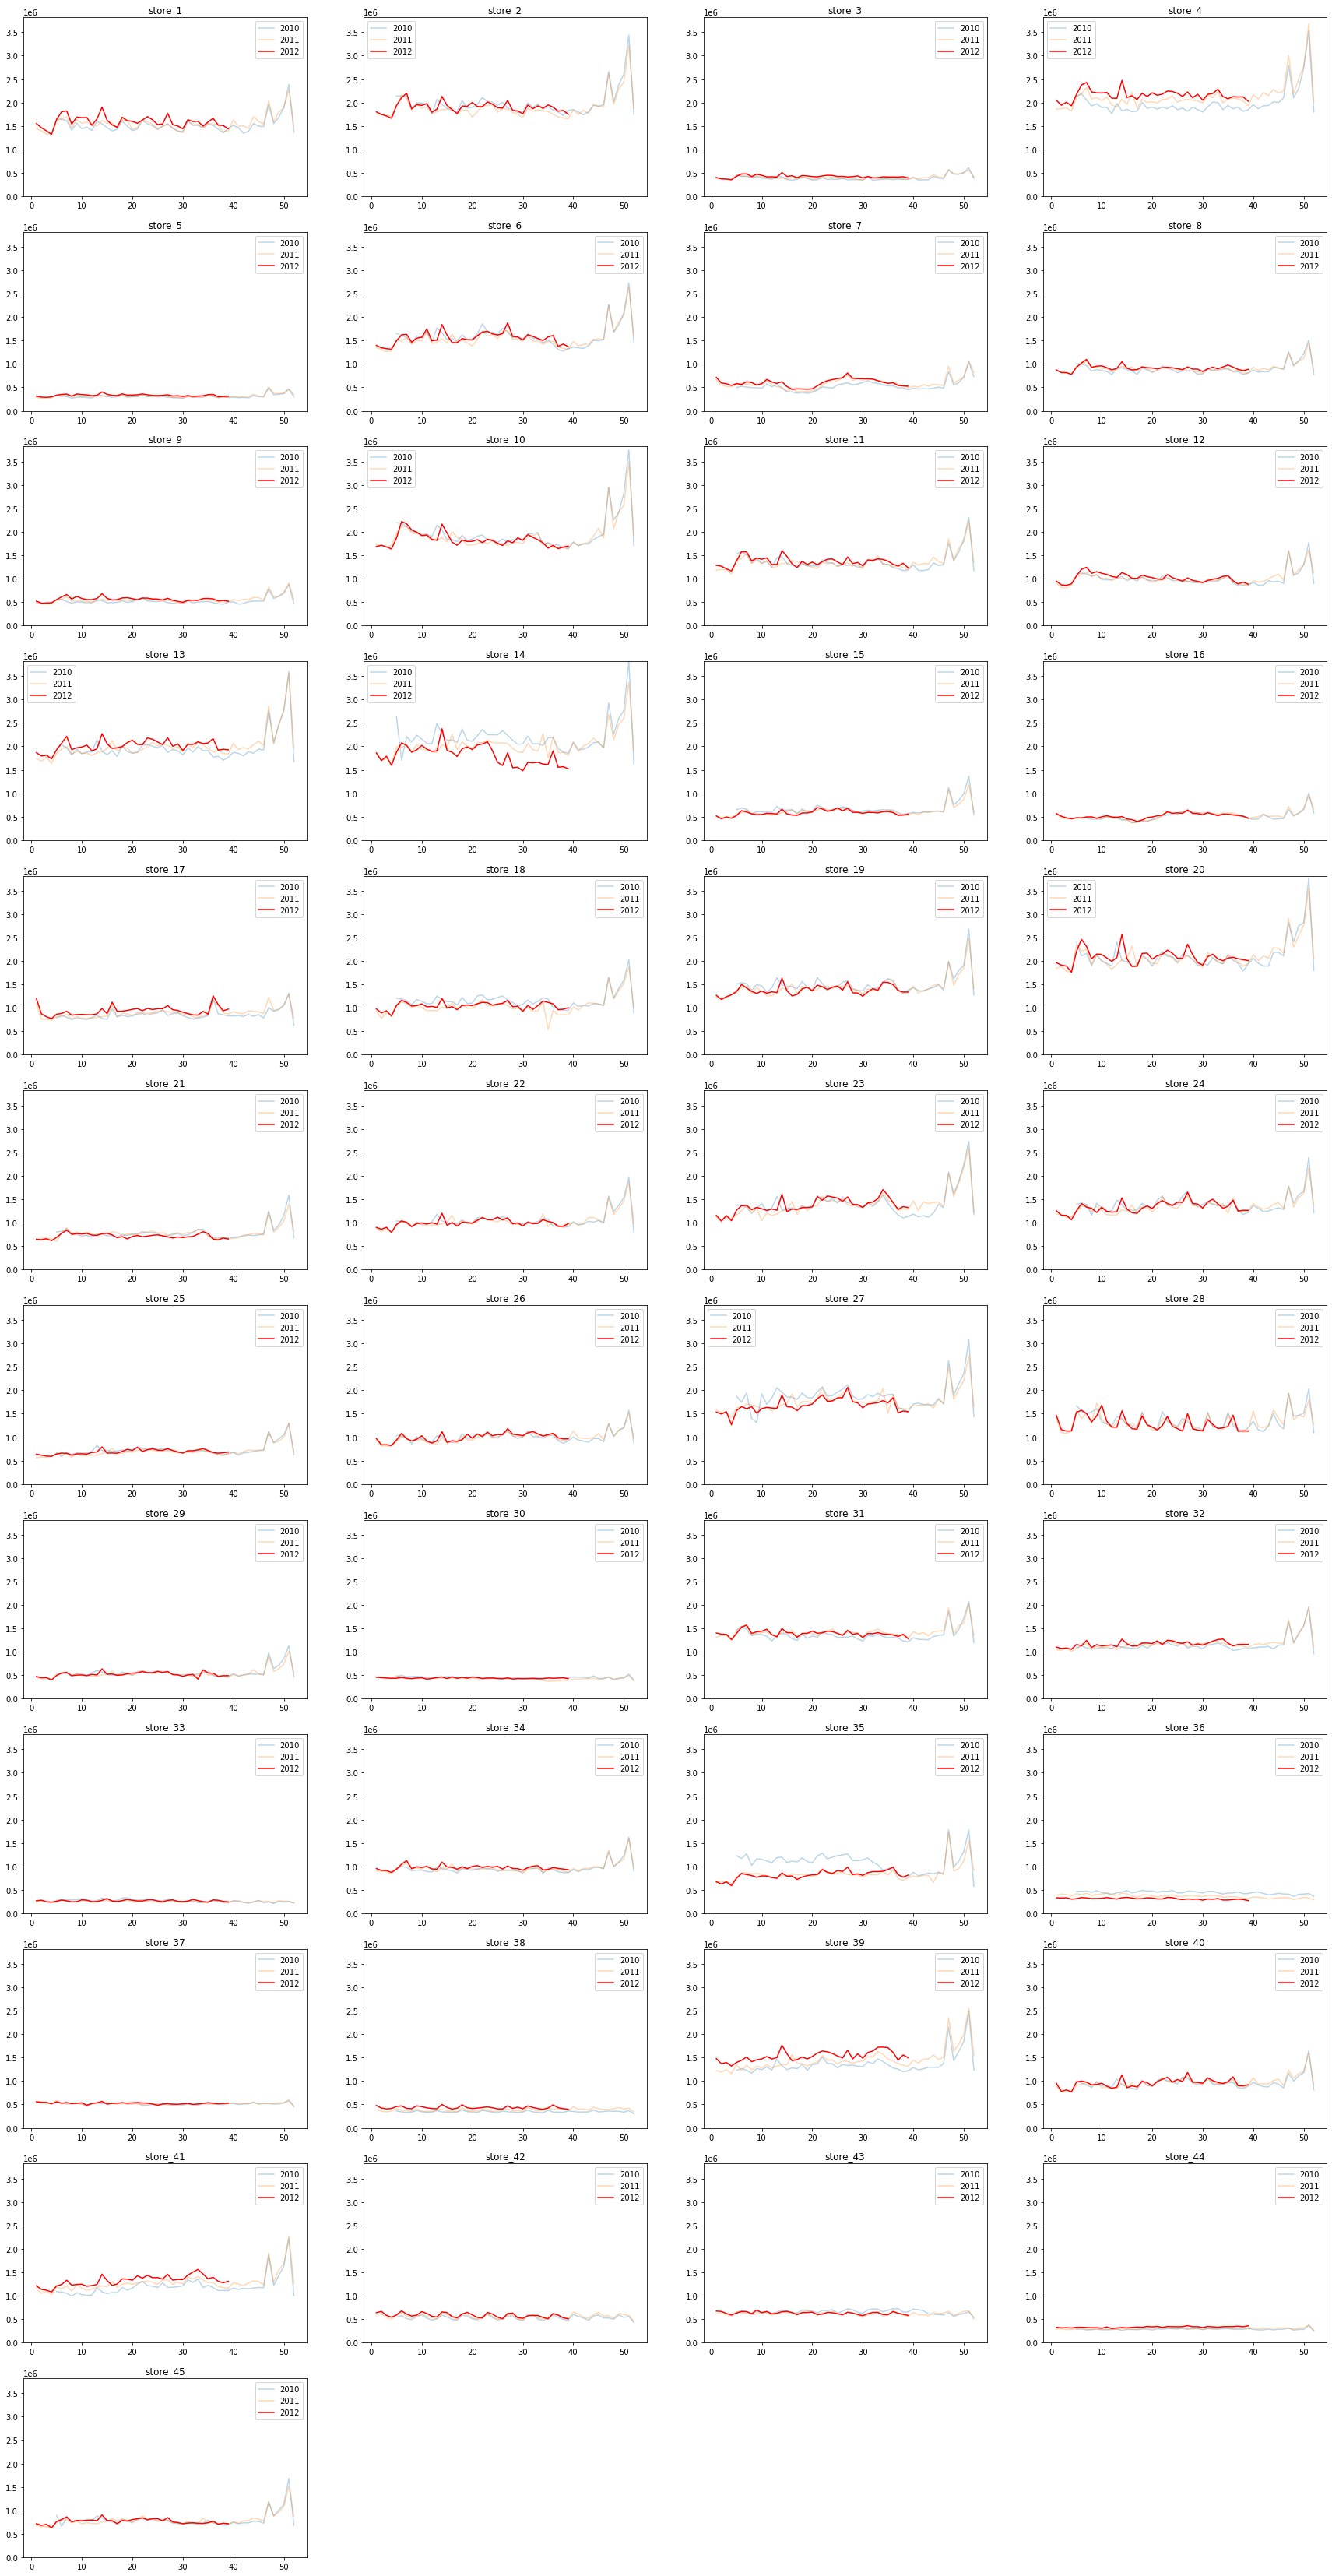

In [7]:
max_sales = max(trainset.Weekly_Sales)

fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[storeset.Year==2010]
    storeset_2011 = storeset[storeset.Year==2011]
    storeset_2012 = storeset[storeset.Year==2012]
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.legend()
    plt.ylim(0, max_sales)
    
plt.show()

When the Y-axis scale (sales amount) is taken equally, it is confirmed that there is a difference in sales amount for each branch

**Differences in sales by branch**

Differentiate the y-axis scale (sales) from branch to branch to see how sales change from year to year for each branch

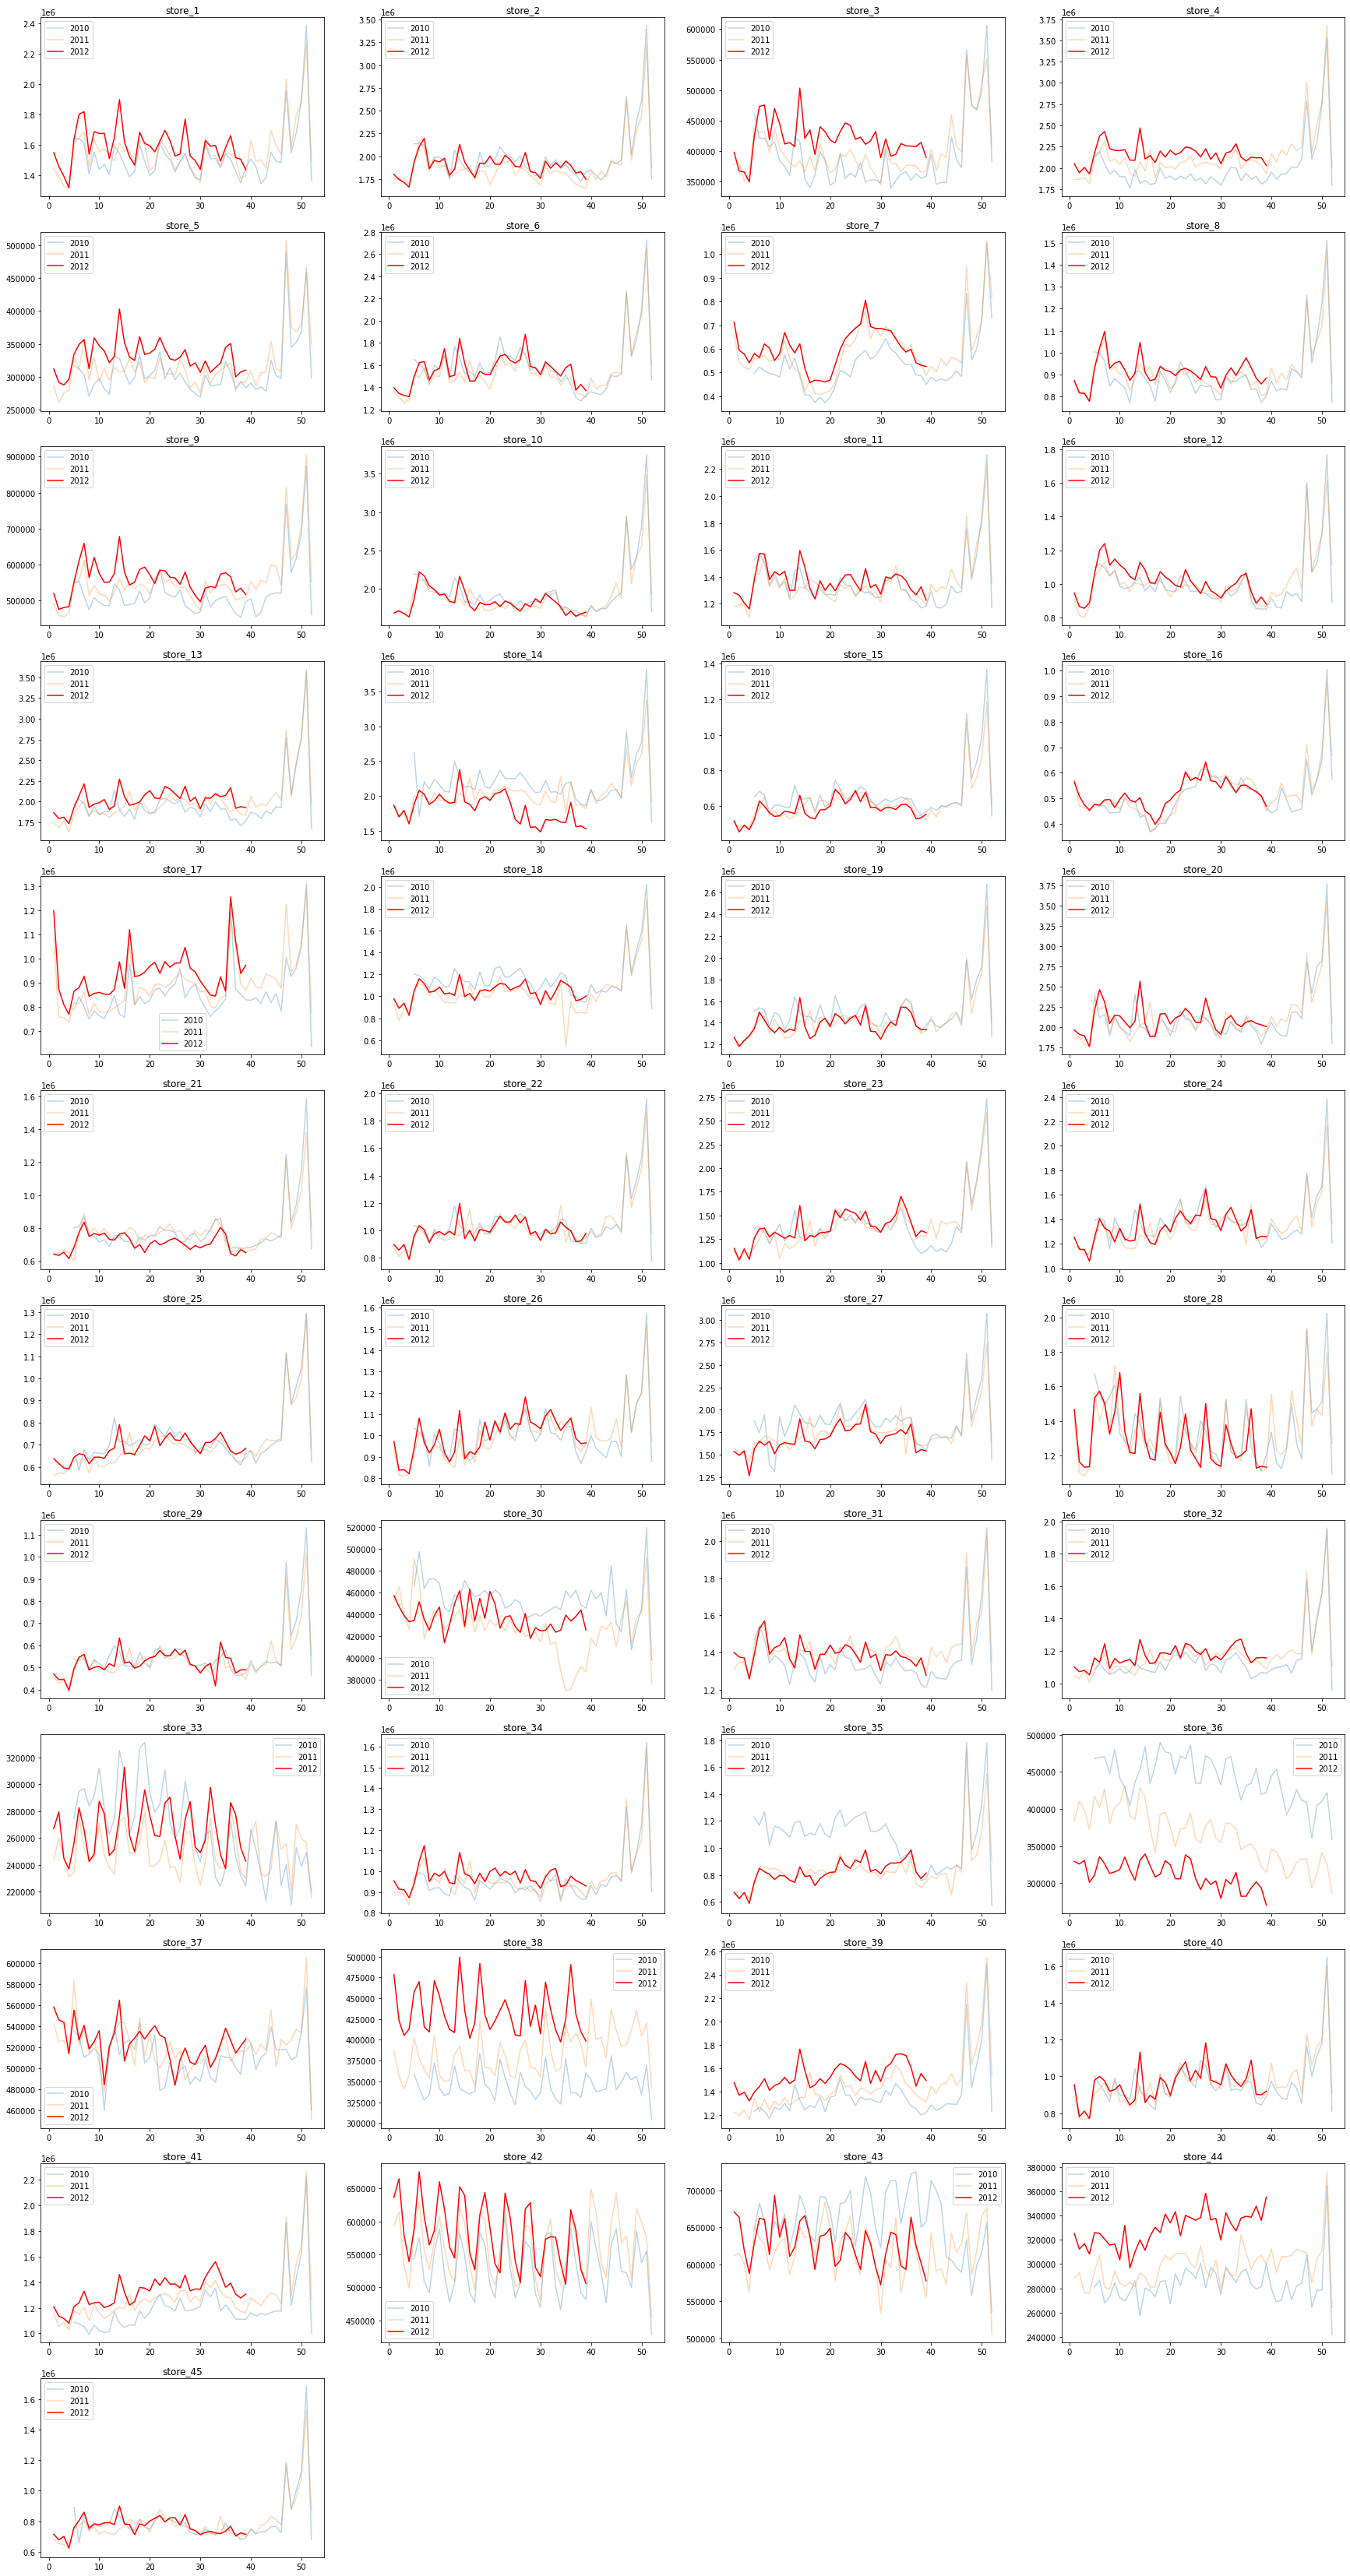

In [8]:
fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[storeset.Year==2010]
    storeset_2011 = storeset[storeset.Year==2011]
    storeset_2012 = storeset[storeset.Year==2012]
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.legend()
    
plt.show()

- Sales trends vary by branch
- In some cases, the weekly change in sales in 2012, which is the target of the forecast, is more similar in 2010 and more similar in 2011.

**Analysis Plan**

- Let's create a prediction model for each point.
- Use the base year (2010 or 2011) and 2012 data.
- Boldly exclude data for non-base years
- Let's choose a year that learns using data from 2010 and 2011 to September and data from 2012 to August and better predicts data from September 2012.
- For the selected base year, let's learn using data from October to September 2012 and finally predict the data from October 2012.

In [9]:
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5

**What ML approach do you use, or what methods does your app use?**

Using xgboost, I constructed the ML model and predicted sales.

In [10]:
models = []

features = ['Store', 'NumberHoliday', 'Week', 'Day', 'Month', 'Year']

model_params = {
    "n_estimators": 60,
    "min_child_weight": 3,
    "max_depth": 6
}

for store in range(1,max(trainset.Store)+1):
    train_store = trainset[trainset.Store==store]
    
# Data segregation by year 2010, 2011, and 2012
# 2012 does not include September because we are trying to predict 2012-09
    train_store_2010 = train_store[(train_store.Year==2010) & (train_store.Month<=9)]
    train_store_2011 = train_store[(train_store.Year==2011) & (train_store.Month<=9)]
    train_store_2012 = train_store[(train_store.Year==2012) & (train_store.Month<9)]
    
# Data generation excluding 2011 and 2010
    train_store_2010_2012 = pd.concat([train_store_2010, train_store_2012])
    train_store_2011_2012 = pd.concat([train_store_2011, train_store_2012])
    
# Learning each model
    model_2010_2012 = xgboost.XGBRegressor(**model_params)
    model_2010_2012.fit(train_store_2010_2012[features],
                        train_store_2010_2012.Weekly_Sales)
    
    model_2011_2012 = xgboost.XGBRegressor(**model_params)
    model_2011_2012.fit(train_store_2011_2012[features],
                        train_store_2011_2012.Weekly_Sales)
    
# Forecast for September 2012
    x_test = train_store[(train_store.Year==2012) & (train_store.Month==9)]
    pred_2010_2012 = model_2010_2012.predict(x_test[features])
    pred_2011_2012 = model_2011_2012.predict(x_test[features])
    
# Evaluating predictive results
    rmse_2010_2012 = RMSE(pred_2010_2012, x_test.Weekly_Sales)
    rmse_2011_2012 = RMSE(pred_2011_2012, x_test.Weekly_Sales)

    
# Select year with less error
    similar_year = 2010
    if rmse_2010_2012 > rmse_2011_2012:
        similar_year = 2011

    print(f"{store:02}", similar_year, rmse_2010_2012, rmse_2011_2012)
    
# Learn with full data
    train_store_target = pd.concat([
        train_store[(train_store.Year==similar_year) & (train_store.Month<=10)],
        train_store[(train_store.Year==2012)]
    ])

    model = xgboost.XGBRegressor(**model_params)
    model.fit(train_store_target[features], train_store_target.Weekly_Sales)
        
    models.append(model)


01 2011 56071.60628930376 47966.89540801353
02 2010 47175.474784723025 56164.34012466764
03 2010 8268.437273769196 13077.708275727478
04 2011 64688.894678747085 60972.94780574236
05 2011 20997.80851191311 12672.798664059448
06 2011 102611.38449136249 45342.36973505723
07 2011 56083.72419064737 33641.41371938894
08 2011 23797.58729987398 16945.440318718218
09 2011 23737.43661794663 19955.845386942805
10 2011 45532.260210964334 29621.423643969756
11 2011 42890.55440611363 27758.395417567135
12 2011 31465.86090392284 27997.49736155524
13 2011 111055.8620250515 77785.7655755382
14 2011 81823.49672589949 38274.45164029742
15 2011 43876.45181115636 29068.893516712713
16 2011 32467.401136668646 29640.638169503323
17 2011 122731.94901927859 83383.88282766515
18 2010 78857.47382519674 124542.191857935
19 2011 49856.77174811298 45042.99211316406
20 2011 60677.63720372219 46180.245373484955
21 2011 44700.81969409519 24391.13108365947
22 2011 41872.45215390406 19681.340013530826
23 2011 151956.306

In [11]:
pred = []
for store in range(1, max(trainset.Store)+1):
    test_store = testset[testset.Store==store]
    
    y = models[store-1].predict(test_store[features])
    pred += y.tolist()

In [12]:
test_pred = testset.copy()
test_pred["Weekly_Sales"] = pred

# Result

**Show the result or run an app demo.**

Below is a graph of estimated sales for each branch.

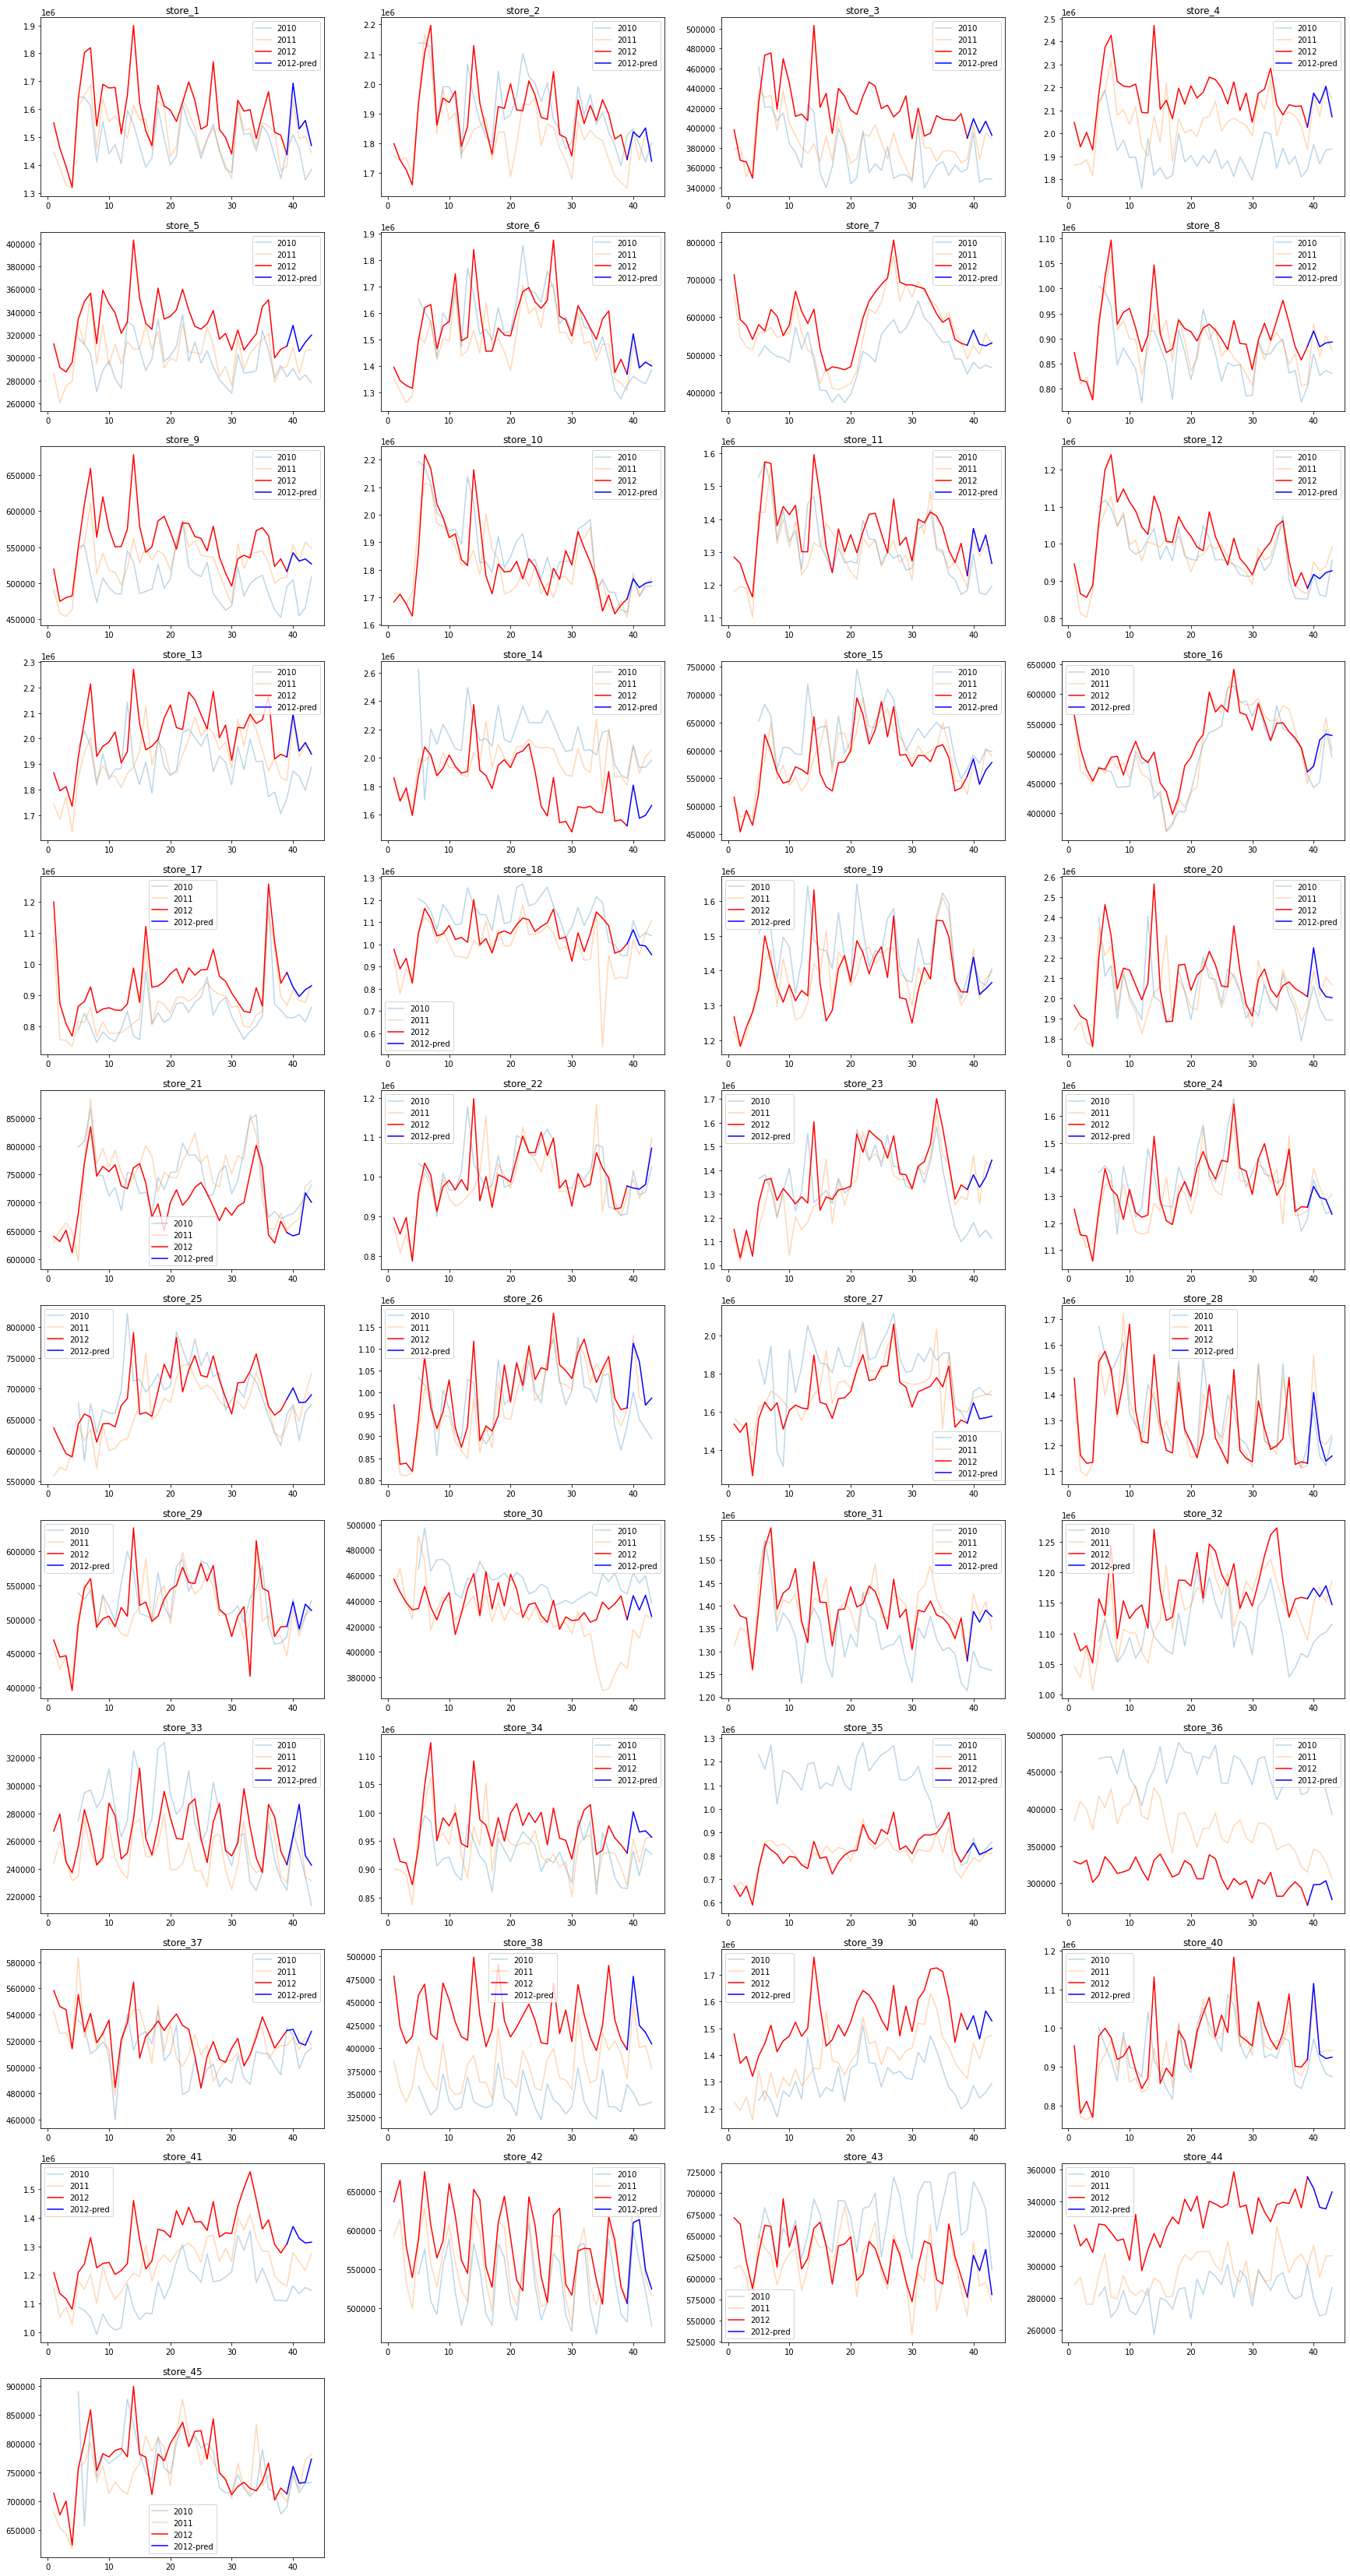

In [13]:
fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[(storeset.Year==2010) & (storeset.Month<=10)]
    storeset_2011 = storeset[(storeset.Year==2011) & (storeset.Month<=10)]
    storeset_2012 = storeset[(storeset.Year==2012) & (storeset.Month<=10)]
    
    test_pred_store = test_pred[test_pred.Store==store]
    
# For the continuity of the graph, the previous week's data of the predicted data is also added.
    test_pred_store = pd.concat([storeset_2012.iloc[-1:], test_pred_store])
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.plot(test_pred_store.Week, test_pred_store.Weekly_Sales, label="2012-pred", color='b')
    ax.legend()
    
plt.show()